# <center>Cancer Prediction<br> SVM Model</center>

In [3]:
# Import required libraries

import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style(style='whitegrid')

# Import data

In [4]:
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2020-01-19 19:37:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: 'cell_samples.csv'

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.1s    

2020-01-19 19:37:29 (201 KB/s) - 'cell_samples.csv' saved [20675/20675]



In [72]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

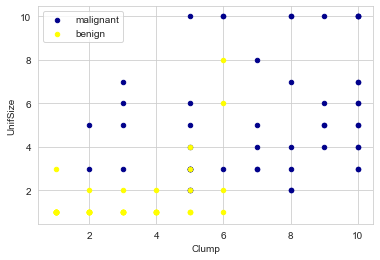

In [37]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant')
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

# Data pre-processing and Feature Selection

In [73]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [74]:
cell_df['BareNuc'].replace('?', '1', inplace=True)

In [75]:
cell_df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

In [77]:
cell_df['BareNuc'] = cell_df['BareNuc'].astype('float')

In [78]:
cell_df.dtypes

ID               int64
Clump            int64
UnifSize         int64
UnifShape        int64
MargAdh          int64
SingEpiSize      int64
BareNuc        float64
BlandChrom       int64
NormNucl         int64
Mit              int64
Class            int64
dtype: object

In [79]:
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')

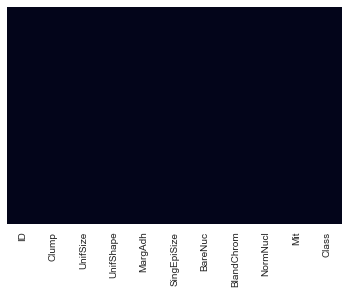

In [80]:
sns.heatmap(cell_df.isnull(), yticklabels=False, cbar=False)

In [81]:
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [82]:
cell_df.corr()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
ID,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.092533,-0.060051,-0.052072,-0.034901,-0.080226
Clump,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.590008,0.558428,0.535835,0.350034,0.716001
UnifSize,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.686673,0.755721,0.722865,0.458693,0.817904
UnifShape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.707474,0.735948,0.719446,0.438911,0.818934
MargAdh,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666971,0.666715,0.603352,0.417633,0.696800
SingEpiSize,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.583701,0.616102,0.628881,0.479101,0.682785
BareNuc,-0.092533,0.590008,0.686673,0.707474,0.666971,0.583701,1.000000,0.674215,0.574778,0.342397,0.818968
BlandChrom,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,0.674215,1.000000,0.665878,0.344169,0.756616
NormNucl,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.574778,0.665878,1.000000,0.428336,0.712244
Mit,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.342397,0.344169,0.428336,1.000000,0.423170


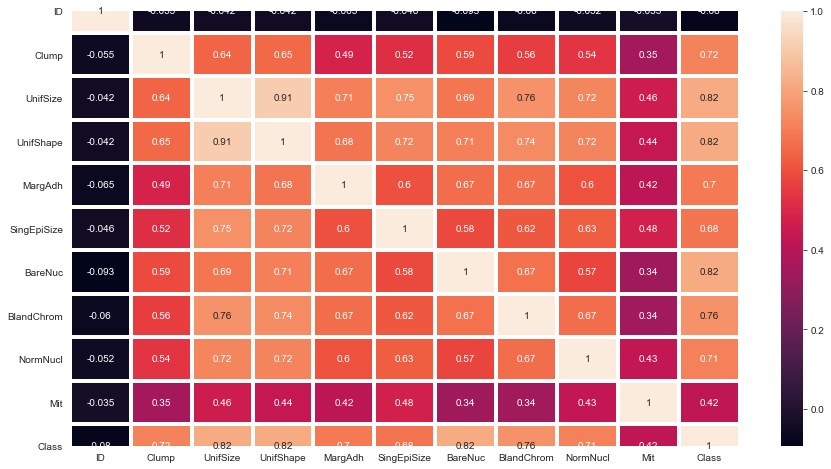

In [83]:
plt.figure(figsize=(15,8))
sns.heatmap(cell_df.corr(), annot=True, linewidth= 3 )

# Feature Set

In [87]:
x = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']].values
x[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [88]:
y = cell_df['Class'].values
y[0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state= 5)
print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (489, 9) (489,)
Test set:  (210, 9) (210,)


# Modelling SVM

In [90]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

/Users/finneysunny/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [91]:
yhat = clf.predict(X_test)
yhat

array([4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2,
       4, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2,
       2, 4, 2, 2, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2,
       2, 4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4,
       4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2,
       4, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       4, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2])

# Evaluation

In [92]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [96]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.98      0.92      0.95       139
           4       0.86      0.97      0.91        71

    accuracy                           0.94       210
   macro avg       0.92      0.95      0.93       210
weighted avg       0.94      0.94      0.94       210

Confusion matrix, without normalization
[[128  11]
 [  2  69]]


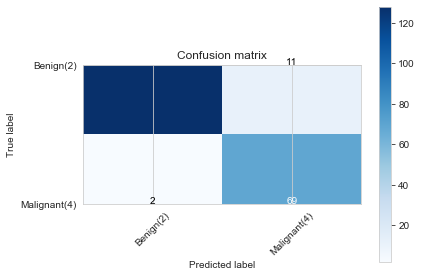

In [97]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)', 'Malignant(4)'], normalize=False, title='Confusion matrix')

In [98]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9389045004742093